# Analysis of the amplitude of the high-frequency harmonics depending on the ADT settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#locked around f = 7600 Hz for 5 hours

data = np.loadtxt('max_aux1all.txt')
data1 = np.loadtxt('max_aux1allgain1.txt')

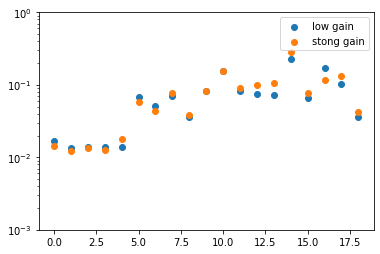

In [3]:
plt.scatter(np.arange(len(data)), data, label = 'low gain') # 931 turns
plt.scatter(np.arange(len(data1)), data1, label = 'stong gain') # 15 turns
plt.yscale('log')
plt.ylim(1e-3,1e0)
plt.legend()

In [4]:
#locked around f = 7800 Hz for 5

data2 = np.loadtxt('max_aux1all1.txt')
data3 = np.loadtxt('max_aux1allgain11.txt')

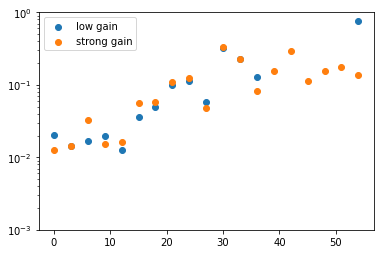

In [5]:
plt.scatter(np.arange(len(data2))*3, data2, label = 'low gain')
plt.scatter(np.arange(len(data3))*3, data3, label = 'strong gain')
plt.yscale('log')
plt.ylim(1e-3,1e0)
plt.legend()

In [6]:
#locked around f = 7800 Hz for 6 hour


data4 = np.loadtxt('max_aux1all1_6.txt')
data5 = np.loadtxt('max_aux1allgain11_6.txt')
len(data4)

19

(0.01, 1)

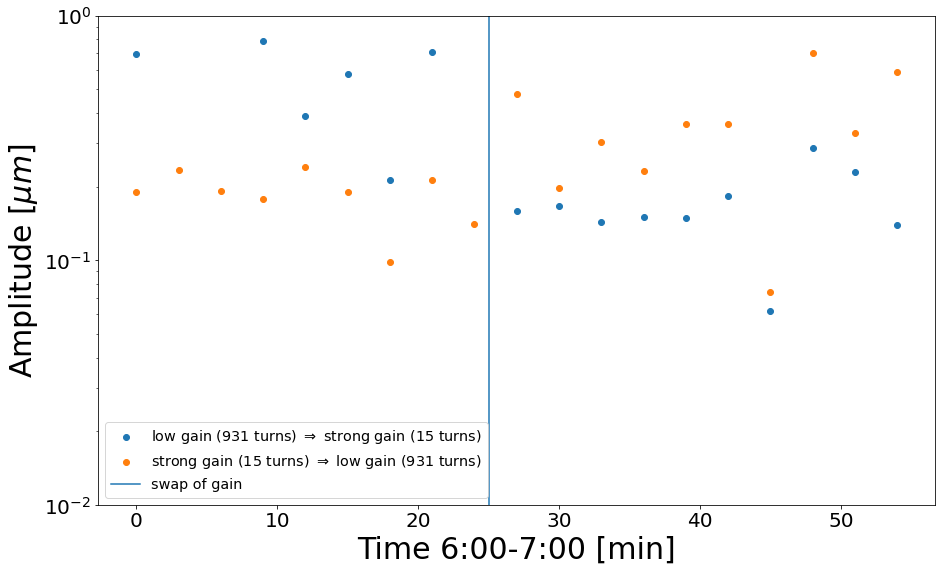

In [7]:
plt.figure(figsize = (15,9))
plt.scatter(np.arange(len(data4))*3, data4, label = 'low gain (931 turns) $\Rightarrow$ strong gain (15 turns)')
plt.scatter(np.arange(len(data5))*3, data5, label = 'strong gain (15 turns) $\Rightarrow$ low gain (931 turns)')
plt.yscale('log')
#plt.ylim(1e-3,1e1)

plt.axvline(5/12*20*3, label = 'swap of gain')
plt.xlabel('Time 6:00-7:00 [min]', size =30)
plt.ylabel('Amplitude [$\mu m$]', size = 30)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 'x-large')
plt.ylim(1e-2,1)

In [8]:
data6 = np.loadtxt('max_aux1allgain11_6try.txt')
data7 = np.loadtxt('max_aux1allgain14_6try.txt')

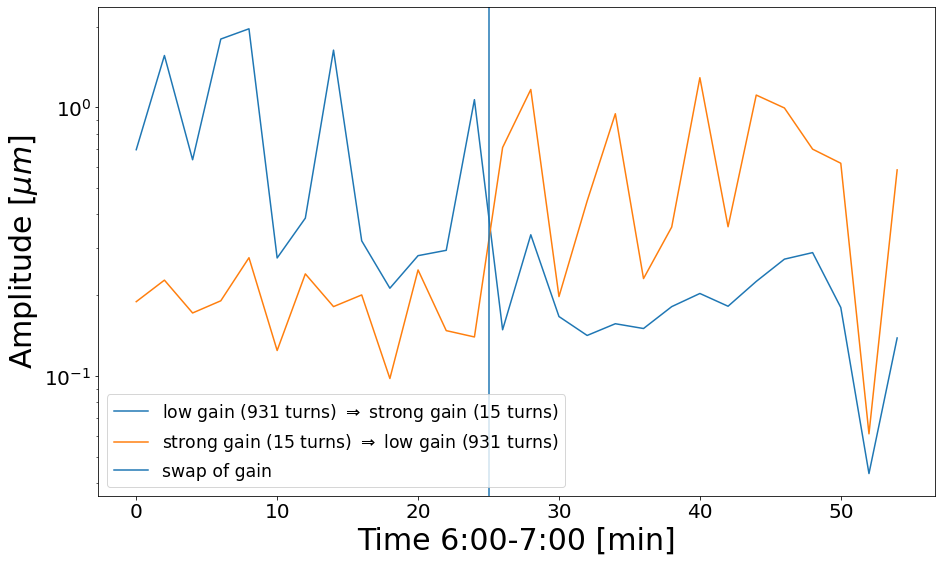

In [9]:
plt.figure(figsize = (15,9))

plt.plot(np.arange(len(data7))*2, data7, label = 'low gain (931 turns) $\Rightarrow$ strong gain (15 turns)')
plt.plot(np.arange(len(data6))*2, data6, label = 'strong gain (15 turns) $\Rightarrow$ low gain (931 turns)')
plt.yscale('log')
#plt.ylim(1e-3,1e1)

plt.axvline(5/12*20*3, label = 'swap of gain')
plt.xlabel('Time 6:00-7:00 [min]', size =30)
plt.ylabel('Amplitude [$\mu m$]', size = 30)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 'xx-large')

# Code below not working

In [10]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=10.0, sigma_f=.01, sigma_y=1e-2):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    
    """
    
    
    
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))

    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()


1.7118478939116082 0.7205890298009446


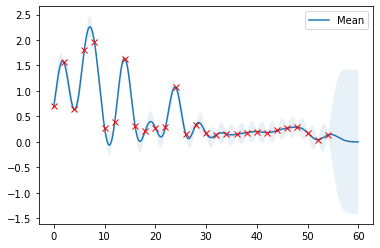

In [263]:
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.

    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (11), if
               False use a numerically more stable implementation.

    Returns:
        Minimization objective.
    """
    
    Y_train = Y_train.ravel()
    
    def nll_naive(theta):
        # Naive implementation of Eq. (11). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
        
    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (11) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        
        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)
        
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.dot(S2) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
noise = 1e-7
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x
#plt.yscale('log')
# Compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_s, cov_s = posterior(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
print(l_opt, sigma_f_opt)

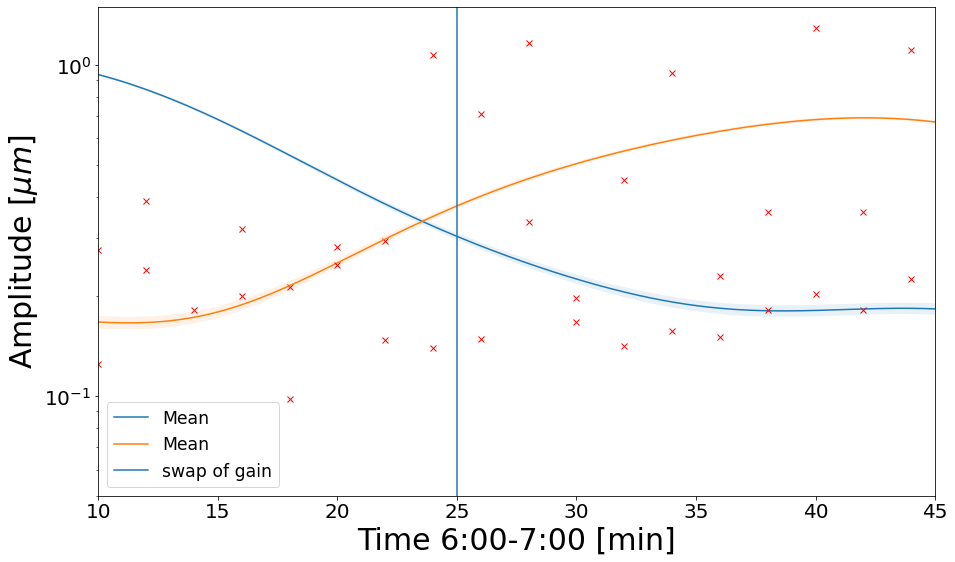

In [266]:

plt.figure(figsize=(15,9))
# Noise free training data
X_train = (np.arange(len(data7))*2).reshape(-1,1)
Y_train = data7.reshape(-1,1)

X_train1 = (np.arange(len(data6))*2).reshape(-1,1)
Y_train1 = data6.reshape(-1,1)

X = np.arange(0,60, 0.05).reshape(-1, 1)


# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)
mu_s1, cov_s1 = posterior(X, X_train1, Y_train1)
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

#plt.yscale('log')
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
plot_gp(mu_s1, cov_s1, X, X_train=X_train1, Y_train=Y_train1)
plt.ylim(5*1e-2,1.5*1e0)
plt.xlim(10, 45)
plt.axvline(5/12*20*3, label = 'swap of gain')
plt.xlabel('Time 6:00-7:00 [min]', size =30)
plt.ylabel('Amplitude [$\mu m$]', size = 30)
plt.yscale('log')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 'xx-large')


In [260]:
data8 = np.loadtxt('first30.txt')
data9 = np.loadtxt('first30-60.txt')

(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

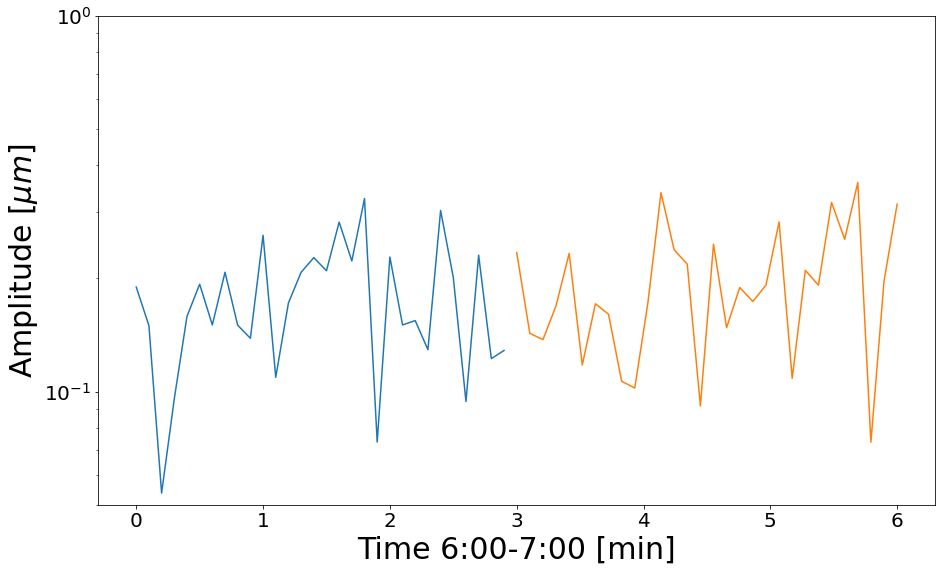

In [261]:

plt.figure(figsize=(15,9))
plt.plot(np.arange(len(data8))/10, data8)
plt.plot(np.linspace(30,60,len(data9))/10, data9)
plt.yscale('log')
plt.ylim(5*1e-2,1e0)
#plt.axvline(5/12*20*3, label = 'swap of gain')
plt.xlabel('Time 6:00-7:00 [min]', size =30)
plt.ylabel('Amplitude [$\mu m$]', size = 30)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#|plt.legend(fontsize = 'xx-large')
